## Log parser

In [46]:
import os
import re
from collections import defaultdict, OrderedDict

In [47]:
log_filename = "../simulation_results/SEIRD_output_state.txt"
dim = 20,20
patt_out_line = "State for model (.+?) is <total_.*? ([0-9.]+)>"

In [48]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INFECTED = "#e74c3c"
COLOR_EXPOSED = "#f1c40f"
COLOR_RECOVERED = "#2ecc71"
COLOR_DEAD = "#9b59b6"

In [49]:
current_vals = OrderedDict()
data = []

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        
        if re.match("[0-9.]+", line):
            current_vals["time"] = line
            
            if len(current_vals) > 1 and (len(data) == 0 or data[-1][0] != float(line)):
                row = [float(current_vals["time"])] + list(map(float, list(current_vals.values())[1:]))
                data.append(row)
            continue
        
        match = re.match(patt_out_line, line)
        if not match:
            raise RuntimeError("Unexpected line: '%s'" % line)
            
        state, val = match.groups()
        current_vals[state] = val

In [50]:
data[:3]

[[0.0, 0.0, 0.0, 4.0, 0.0, 7999996.0],
 [0.1, 0.0, 0.0, 4.0, 0.0, 7999996.0],
 [0.2, 0.0, 0.0, 3.97, 0.0, 7999995.0]]

## Dataframe creation and visualization

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
df_log = pd.DataFrame(data, columns=current_vals.keys())
df_ref = pd.read_csv("data/insightmaker0.1.csv")
df_ref.head()

,Time,Exposed,Death,Recovered,Susceptible,Infective,to exposed
0,0.0,0.000000,0.000000e+00,0.000000,8.000000e+06,0.000000,4.000000
1,0.1,0.400000,0.000000e+00,0.000000,8.000000e+06,0.000000,4.000000
2,0.2,0.793730,0.000000e+00,0.000000,7.999999e+06,0.006270,4.019539
3,0.3,1.183243,3.703373e-07,0.000043,7.999999e+06,0.018667,0.058174
4,0.4,1.170515,1.472971e-06,0.000172,7.999999e+06,0.037083,0.115567


In [43]:
max_time = min(max(df_ref["Time"]), max(df_log["time"]))
df_vis = df_log[df_log["time"] < max_time]  # To cropping the data to the useful time slot
#df_vis = df_vis.set_index("time")
df_vis.head()

,time,recovered,deceased,infective,exposed,susceptible
0,0.0,0.00,0.0,4.00,0.00,7999996.0
1,0.1,0.00,0.0,4.00,0.00,7999996.0
2,0.2,0.00,0.0,3.97,0.00,7999995.0
3,0.3,0.03,0.0,3.94,1.25,7999994.0
4,0.4,0.06,0.0,3.91,2.46,7999993.0


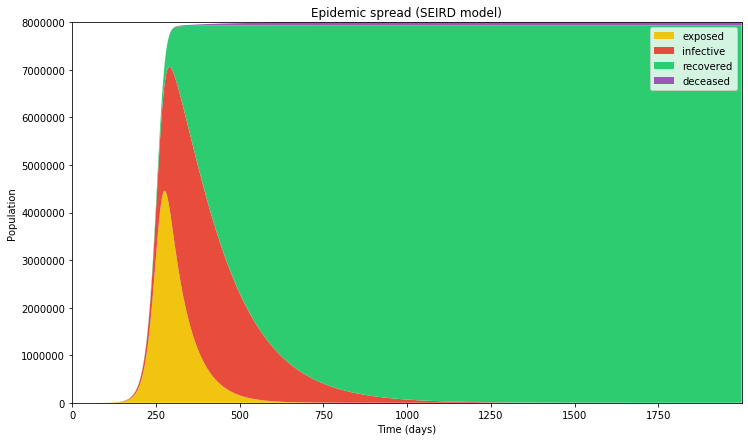

In [44]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["exposed", "infective", "recovered", "deceased"]
colors=[COLOR_EXPOSED, COLOR_INFECTED, COLOR_RECOVERED, COLOR_DEAD]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic spread (SEIRD model)')
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.savefig(base_name + "_area.png")

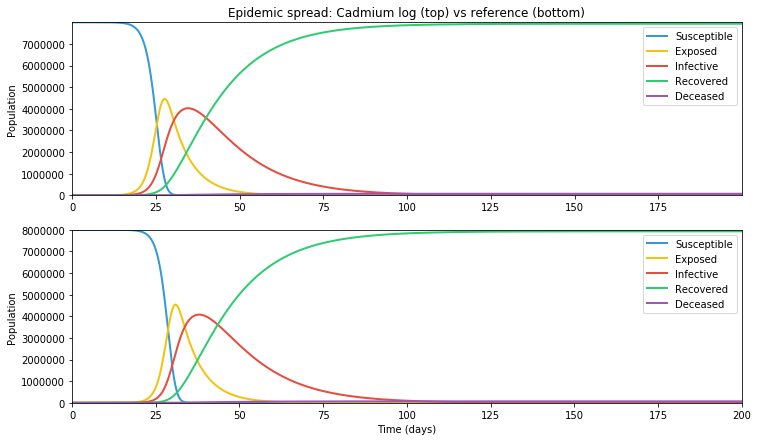

In [45]:
fig, axs = plt.subplots(2, figsize=(12,7))
linewidth = 2

x = list(df_vis["time"])
axs[0].plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[0].plot(x, df_vis["exposed"], label="Exposed", color=COLOR_EXPOSED, linewidth=linewidth)
axs[0].plot(x, df_vis["infective"], label="Infective", color=COLOR_INFECTED, linewidth=linewidth)
axs[0].plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth)
axs[0].plot(x, df_vis["deceased"], label="Deceased", color=COLOR_DEAD, linewidth=linewidth)
axs[0].legend(loc='upper right')
axs[0].set_ylabel("Population")
axs[0].margins(0,0)

x = list(df_ref["Time"])
axs[1].plot(x, df_ref["Susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[1].plot(x, df_ref["Exposed"], label="Exposed", color=COLOR_EXPOSED, linewidth=linewidth)
axs[1].plot(x, df_ref["Infective"], label="Infective", color=COLOR_INFECTED, linewidth=linewidth)
axs[1].plot(x, df_ref["Recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth)
axs[1].plot(x, df_ref["Death"], label="Deceased", color=COLOR_DEAD, linewidth=linewidth)
axs[1].legend(loc='upper right')
axs[1].set_ylabel("Population")
plt.margins(0,0)

axs[0].set_title('Epidemic spread: Cadmium log (top) vs reference (bottom)')
axs[1].set_xlabel("Time (days)")
plt.ylabel("Population")
plt.savefig(base_name + "_lines2.png")